In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

torch.set_default_dtype(torch.float32)

In [3]:
data_dict = torch.load('../../data/summarized_neutron_data_w_bkg_260meV_ML.pt')
print(data_dict.keys())

dict_keys(['grid', 'S', 'background', 'background_dict'])


In [4]:
data_dict['grid']['l_grid']

tensor([-10.0000,  -9.5000,  -9.0000,  -8.5000,  -8.0000,  -7.5000,  -7.0000,
         -6.5000,  -6.0000,  -5.5000,  -5.0000,  -4.5000,  -4.0000,  -3.5000,
         -3.0000,  -2.5000,  -2.0000,  -1.5000,  -1.0000,  -0.5000,   0.0000,
          0.5000,   1.0000,   1.5000,   2.0000,   2.5000,   3.0000,   3.5000,
          4.0000,   4.5000], dtype=torch.float64)

In [5]:
hklw_grid = torch.vstack([_.unsqueeze(0) for _ in torch.meshgrid(*[v for k, v in data_dict['grid'].items()], indexing='ij')]).permute(1, 2, 3, 4, 0)

In [6]:
mask = data_dict['S'] > 1e-3

In [7]:
import numpy as np
from scipy.ndimage import binary_erosion

# Erode the mask to remove boundary points
eroded_mask = binary_erosion(mask, iterations=2)

# Extract interior points
interior_points = np.transpose(np.nonzero(eroded_mask))

print("Interior Points:")
print(interior_points)

Interior Points:
[[  2   2   7   2]
 [  2   2   7  10]
 [  2   2   7  14]
 ...
 [118 118  17  25]
 [118 118  18  22]
 [118 118  18  23]]


In [23]:
from src.data_utils import get_neighbors

In [24]:
# 2D example
# index = torch.tensor([[0, 0], [4, 5], [6, 7]])
# neighbors = get_neighbors(index, dim=2, neighbor_range=1, return_flat=False)

# 3D example
index = torch.tensor([[1, 2, 3], [5, 6, 7]])
neighbors = get_neighbors(index, dim=3, neighbor_range=1, return_flat=False)

In [25]:
from src.sqw import SpecNeuralRepr

In [26]:
model_sqw = SpecNeuralRepr.load_from_checkpoint('input/version_14896845/checkpoints/epoch=7160-step=343728.ckpt')

In [27]:
from src.qpath import linspace_2D_equidistant

kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
wpts = data_dict['grid']['w_grid']

In [28]:
_l = data_dict['grid']['l_grid'][0]

params = torch.tensor([29, 1.7])

x_input = torch.zeros(wpts.shape[0], kpts.shape[0], 6)
x_input[...,:4] = torch.cat([
    kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
    _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
    wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
   ], dim=2)
x_input[...,4:] = params

In [29]:
S_pred = model_sqw.forward_qwp(x_input.to(model_sqw.device)).detach().cpu().numpy()

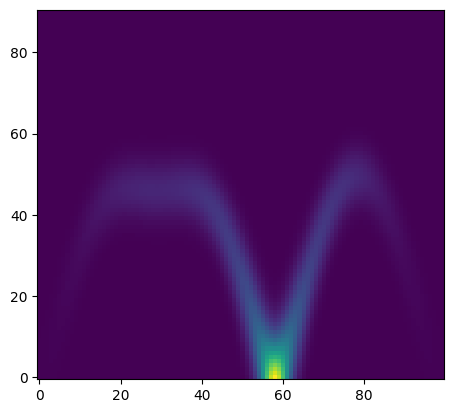

In [30]:
import matplotlib.pyplot as plt

plt.imshow(S_pred, origin='lower')

In [41]:
from src.data_utils import get_neighbors, func_index_tensor

idx_centers = torch.from_numpy(interior_points[:2])
idx_neighbs, _ = get_neighbors(idx_centers, dim=4, neighbor_range=1, return_flat=False, exclude_corner=True)

In [42]:
model_sqw.params = torch.tensor([29, 1.7])

In [43]:
from src.siren import SirenNet

In [44]:
kernel_net = torch.nn.Sequential(
    SirenNet(
        dim_in = 4,
        dim_hidden = 256,
        dim_out = 256,
        num_layers = 3,
        w0_initial = 30.,
        final_activation = torch.nn.ReLU()
    ),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 5**4),
    torch.nn.Softmax(dim=-1)
)

kernel_net.to(model_sqw.device);

In [45]:
q_centers = func_index_tensor(hklw_grid, idx_centers)
q_neighbs = func_index_tensor(hklw_grid, idx_neighbs)

In [46]:
kernel_net(func_index_tensor(hklw_grid, idx_neighbs).to(model_sqw.device).to(model_sqw.dtype)).shape

torch.Size([2, 3, 3, 3, 3, 625])

In [47]:
kappa = kernel_net(q_centers.to(model_sqw.device).to(model_sqw.dtype))

In [48]:
s_neighbors = model_sqw.forward_qw(q_neighbs.to(model_sqw.device).to(model_sqw.dtype))

In [49]:
s_neighbors.shape

torch.Size([2, 3, 3, 3, 3])

In [50]:
from src.dataset import NeighborDataset

In [51]:
dataset = NeighborDataset(hklw_grid, data_dict['S'], neighbor_range=2)

In [52]:
from torch.utils.data import DataLoader

In [53]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [54]:
batch = next(iter(dataloader))

In [55]:
for k, v in batch.items():
    print(k, v.shape)
    
device = model_sqw.device
dtype = model_sqw.dtype

kernel_net.to(device).to(dtype);

center_pts torch.Size([2, 4])
neighb_pts torch.Size([2, 625, 4])
neighb_mask torch.Size([2, 625])
center_data torch.Size([2, 1])


In [56]:
kappa = kernel_net(batch['center_pts'].to(device).to(dtype))
neighb_data = model_sqw.forward_qw(batch['neighb_pts'].to(device).to(dtype))

In [57]:
s_pred = torch.einsum('ij, ij -> i', kappa, neighb_data)

In [58]:
s_target = batch['center_data']

In [59]:
from src.kernel import KernelNet

In [66]:
import torch
import torch.nn as nn
import lightning

class L_Kernel(lightning.LightningModule):
    def __init__(self, forward_model, dim=3, neighbor_range=1, exclude_corner=True):
        super().__init__()
        self.save_hyperparameters()
        
        self.dim = dim
        self.neighbor_range = neighbor_range
        self.exclude_corner = exclude_corner
        
        self.kernel_net = KernelNet(
            dim=dim, neighbor_range=neighbor_range, 
            exclude_corner=exclude_corner)
        # self.bkgd_net = SirenNet(
        #         dim_in = dim,
        #         dim_hidden = self.kernel_net.hidden_dim,
        #         dim_out = 1,
        #         num_layers = self.kernel_net.num_layers,
        #         w0_initial = 30.,
        #         final_activation = torch.nn.ReLU()
        # )
        self.forward_model = forward_model
        
    def forward(self, x):
        return self.kernel_net(x)
    
    def compute_metrics_on_batch(self, batch):
        kappa = self.forward(
            batch['center_pts'].to(self.dtype).to(self.device))
        neighb_data = self.forward_model.forward_qw(
            batch['neighb_pts'].to(self.dtype).to(self.device))
        s_sig = torch.einsum(
            'ij, ij -> i', 
            kappa, neighb_data[:,self.kernel_net.kernel_mask_flat]
        ).unsqueeze(-1)
        s_pred = s_sig
        # s_bkg = self.bkgd_net(batch['center_pts'].to(self.dtype).to(self.device))
        # s_pred = s_sig + s_bkg
        s_target = batch['center_data']
        loss = torch.nn.functional.mse_loss(s_pred.cpu(), s_target.cpu())
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self.compute_metrics_on_batch(batch)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [67]:
from src.dataset import NeighborDataset
from torch.utils.data import DataLoader

In [68]:
dataset = NeighborDataset(hklw_grid, data_dict['S'], neighbor_range=2)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [69]:
L_model = L_Kernel(forward_model=model_sqw, dim=4, neighbor_range=2, exclude_corner=True).to(device)

In [70]:
batch = next(iter(dataloader))

In [71]:
L_model.compute_metrics_on_batch(batch)

tensor(133.3252, grad_fn=<MseLossBackward0>)